## Imports

In [2]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry, EllipticalAperture, EllipticalAnnulus
from photutils import Background2D, MedianBackground
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import glob
from astropy.time import Time
from photutils.profiles import RadialProfile
import subprocess
import warnings
warnings.filterwarnings('ignore')

/var/folders/l3/kynmmffn6mb9tjg_c1n4qtd80000gn/T/ipykernel_68446/57300138.py:4: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, MedianBackground
/var/folders/l3/kynmmffn6mb9tjg_c1n4qtd80000gn/T/ipykernel_68446/57300138.py:4: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D, MedianBackground


## Definitions

#### This is long but it is where all the juicy parts are (photometry, error calculation, conversion to magnitude, etc)
#### User should not need to change any of this

In [6]:
class PhotometryPipeline:
    """
    Encapsulates relative photometry steps: performing photometry,
    calculating aperture-scale ratios, and finding magnitudes.
    """
    def __init__(self,
                 file_dir: str,
                 star_list_pix: list,
                 ref_image: str = None,
                 target_name: str = None,
                 aperture_radius: float = 8,
                 annulus_inner: float = 22,
                 annulus_outer: float = 30,
                 afactor: float = 1.0,
                 bfactor: float = 1.0,
                 gap: float = 5.0,
                 theta: float = 0,
                 gain: float = None,
                 rdnoise: float = 2.8):
        self.file_dir = file_dir
        self.star_list_pix = star_list_pix
        self.ref_image = ref_image
        self.target_name = target_name
        self.ap_radius = aperture_radius
        self.an_inner = annulus_inner
        self.an_outer = annulus_outer
        self.a = afactor
        self.b = bfactor
        self.gap = gap
        self.theta = theta
        self.gain = gain
        self.rdnoise = rdnoise
        '''The above parameters are default values and can be changed if needed
        The value are set when you run it.
        The gain and rdnoise are set to correct values (MAY 2025 RLMT) but can be changed if needed
        GAIN will read from the header if set to None, this is currently set to use 4*egain due to binning
        '''

    def _load_images(self, filt):
        path = os.path.join(self.file_dir, filt) + '/'
        patterns = ['*.fts', '*.fit', '*.fits']
        files = []
        for p in patterns:
            files += glob.glob(os.path.join(path, p))
        return sorted(files)

    def _read_header(self, fname):
        hdr = fits.getheader(fname)
        if self.gain is None:
            egain = hdr.get('EGAIN', 1)
            self.gain = 4 * egain
        return hdr
    
    def perform_phot(self, filt, 
                     save=True, 
                     plot=True, 
                     save_ref_star_coords=False, 
                     display_apertures=False, 
                     HJD = False, 
                     use_hdr_ap = False,
                     large_ap = False):
        '''
        Perform relative photometry on a set of images
        Variable FWHM photometry in different defn
        By default the code will save to a csv file and plot results, this can be turned off with flags
        '''
        images = self._load_images(filt)
        if not images:
            raise FileNotFoundError(f"No images for filter {filt}")
        ref = self.ref_image or images[0]
        hdr = self._read_header(ref)
        wcs = WCS(hdr)
        # convert pix->world->pix for all
        coords = [wcs.all_pix2world(x, y, 0) for x, y in self.star_list_pix]
        # add the target star to the list
        if self.target_name is None:
            try:
                target_name = hdr['BLKNAME']
            except KeyError:
                target_name = hdr['OBJECT']
            print('Target Name:', target_name)
        else:
            target_name = self.target_name
            print('Target Name:', target_name)
        # Convert the target coordinates to degrees
        target = SkyCoord.from_name(target_name)
        ra = target.ra.deg
        dec = target.dec.deg
        print('Target RA:', ra)
        print('Target Dec:', dec)
        coords = [(ra, dec)] + coords
        all_results = []
        for im in images:
            data = fits.getdata(im)
            hdr = fits.getheader(im)
            wcs = WCS(hdr)
            xy = [wcs.all_world2pix(ra, dec, 0) for ra, dec in coords]
            if save_ref_star_coords:
                star_list_saving = pd.DataFrame(coords, columns=['RA', 'Dec'])
                target_name = target_name.replace(' ', '_')
                star_list_saving.to_csv(self.file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
                print('Saving reference star coordinates to', target_name + '_ref_star_coords.csv') 
            exptime = hdr['EXPTIME']
            if HJD:
                # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
                exptime = hdr['EXPTIME']
                exptimedays = exptime/(24*3600)
                addjd = exptimedays/2
                jd = hdr['HJD'] + addjd
            else:
                jd = hdr['JD'] + exptime/(2*86400)
            file_results = {'file': im, 'Julian_Date': jd}
            sigclip = SigmaClip(sigma=3., maxiters=10)
            skip_file = False
            for i, (x, y) in enumerate(xy):
                if use_hdr_ap:
                    ap_r = hdr['AP_R']
                    an_i = hdr['AN_R1']
                    an_o = hdr['AN_R2']
                else:
                    ap_r = self.ap_radius
                    an_i = self.an_inner
                    an_o = self.an_outer
                if large_ap:
                    ap_r = ap_r * 2.5
                ap = CircularAperture((x, y), r=ap_r)
                an = CircularAnnulus((x, y), r_in=an_i, r_out=an_o)
                bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
                ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)

                # Recentroid the aperture
                x, y = ap_stats.centroid
            
        
                aperture = CircularAperture((x, y), r=ap_r)
                annulus_aperture = CircularAnnulus((x, y), r_in=an_i, r_out=an_o)
            
                # Perform aperture photometry
                phot_table = aperture_photometry(data, aperture)
                bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
                # Calculate the background in the annulus
                bkg_mean = bkgstats.mean
                bkg_sum = bkg_mean * aperture.area
            
                # Subtract the pedestal from the background for the error calculation
                bkg_mean_nopedestal = bkg_mean-1000
                bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area
            
                # Subtract the background from the aperture photometry
                source_sum = phot_table['aperture_sum'][0]*self.gain - bkg_sum*self.gain

                # Check if the source sum is negative and skip if it is
                if source_sum < 0:
                    print(f"Skipping {im} due to negative source sum, image should be inspected.")
                    skip_file = True
                    break

                # Error calculation (Poisson noise + background noise + read noise)
                error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*self.gain + ((aperture.area)/annulus_aperture.area)*bkg_sum_nopedestal*self.gain + aperture.area*self.rdnoise**2)

                # Optionally turn into a magnitude (not used here but useful for reference)
                source_mag = -2.5 * np.log10(source_sum / exptime)
                source_mag_err = 1.0857 * error / source_sum

                # Store the results with dynamic column names
                file_results[f'star_{i}_x'] = x
                file_results[f'star_{i}_y'] = y
                file_results[f'star_{i}_flux'] = source_sum
                file_results[f'star_{i}_error'] = error
                file_results[f'star_{i}_background'] = bkg_sum                

            # Optionally, display the image with the apertures and annuli (set flag to True)
            # This is useful for checking the positions of the stars are correct
            if display_apertures:
                plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
                for (x, y) in self.star_list_pix:
                    aperture = CircularAperture((x, y), r=ap_r)
                    annulus_aperture = CircularAnnulus((x, y), r_in=an_i, r_out=an_o)
                    aperture.plot(color='blue', lw=1.5)
                    annulus_aperture.plot(color='red', lw=1.5)
                plt.show()   

            # Append the results for this file to the list of all results
            if not skip_file:
                all_results.append(file_results) 
            if skip_file:
                print(f"Skipping {im} due to negative source sum!, image should be inspected.")
                continue

        # Convert the results to a DataFrame for easy analysis
        results_df = pd.DataFrame(all_results)

        # Rename the columns to remove the 'star_0_' prefix for the first star
        # and replace it with 'target_' for clarity
        results_df.rename(
        columns=lambda c: c.replace("star_0_", "target_")
        if c.startswith("star_0_") else c,
        inplace=True
        )
        
        # add all the comparison stars together
        results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux']
    
        # calculate the relative flux of the target star
        results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

        # calculate the relative flux of the comparison stars
        for i in range(1,6):
            results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

        # calculate the error on the total flux
        total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

        #calculate the error on the relative flux
        results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

        # Normalize the relative flux
        mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
        results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
        results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

        # Save the results to a CSV file
        if save:
            results_df.to_csv(self.file_dir + 'Results_' + filt + '.csv', index=False)

        if plot:
            #Plot the relative flux
            #plt.plot(results_df['Julian_Date'], results_df['target_rel_flux'], 'o')
            plt.errorbar(results_df['Julian_Date'], results_df['target_rel_flux'], yerr=results_df['target_relerror'], fmt='o')
            plt.xlabel('Julian Date')
            plt.ylabel('Relative Flux')
            plt.show()
        # Return the results DataFrame
        return results_df

    def perform_e_ap_phot(self, filt,
        save = True,
        plot = True,
        display_apertures = False, # display the apertures and annuli on the reference image
        save_ref_star_coords = False, # save the star list in ra/dec coords for reference image
        ):
        '''
        Function to perform elliptical aperture photometry on the images (for windy or bouncy images)
        '''
        # load images
        images = self._load_images(filt)
        if not images:
            raise FileNotFoundError(f"No images for filter {filt}")
        # read header and world coords of reference
        ref = self.ref_image or images[0]
        hdr = self._read_header(ref)
        wcs = WCS(hdr)
        coords = [wcs.all_pix2world(x, y, 0) for x, y in self.star_list_pix]
        # set default apertures from instance values
        a = self.a * self.ap_radius
        b = self.b * self.ap_radius
        a_in = a + self.gap
        a_out = a_in + 5
        b_in = b + self.gap
        b_out = b_in + 5
        if self.target_name is None:
            try:
                target_name = hdr['BLKNAME']
            except KeyError:
                target_name = hdr['OBJECT']
            print('Target Name:', target_name)
        else:
            target_name = self.target_name
            print('Target Name:', target_name)
        # Convert the target coordinates to degrees
        target = SkyCoord.from_name(target_name)
        ra = target.ra.deg
        dec = target.dec.deg
        print('Target RA:', ra)
        print('Target Dec:', dec)
        coords = [(ra, dec)] + coords
        all_results = []
        # Check if the reference star coordinates are provided
        # if ref_star_coords:
        #     print('Using reference star coordinates')
        #     star_list_ra_dec = pd.read_csv(ref_star_coords).values.tolist()
        # Convert the star list from pixel coordinates to RA/Dec coordinates
        # Initialize a list to store results for all files
        for im in images:
            data = fits.getdata(im)
            hdr = fits.getheader(im)
            wcs = WCS(hdr)
            xy = [wcs.all_world2pix(ra, dec, 0) for ra, dec in coords]
            if save_ref_star_coords:
                star_list_saving = pd.DataFrame(coords, columns=['RA', 'Dec'])
                target_name = target_name.replace(' ', '_')
                star_list_saving.to_csv(self.file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
                print('Saving reference star coordinates to', target_name + '_ref_star_coords.csv')
        
            # Pull the exposure time from the header, convert to days 
            # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
            exptime = hdr['EXPTIME']
            exptimedays = exptime/(24*3600)
            addjd = exptimedays/2
            jd = hdr['JD']
            file_results = {'file': im, 'Julian_Date': (jd+addjd)}

            #Make a 2D background model of the image
            # bkg_estimator = MedianBackground()
            # bkg = Background2D(data, (30, 30), filter_size=(3, 3), sigma_clip=SigmaClip(sigma=3), bkg_estimator=bkg_estimator)
            # new_data = data - bkg.background

            # Stats for sigma clipping
            sigclip = SigmaClip(sigma=3., maxiters=10)

            # Perform aperture photometry for each star
            for i, (x, y) in enumerate(xy):
                ap = EllipticalAperture((x, y), a=a, b=b, theta = self.theta)
                an = EllipticalAnnulus((x, y), a_in=a_in, a_out=a_out, b_in=b_in, b_out=b_out, theta = self.theta)
                bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
                ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)

                # Recentroid the aperture
                x, y = ap_stats.centroid #not sure this will work with elliptical apertures
            
        
                aperture = EllipticalAperture((x, y), a= a, b=b, theta=self.theta)
                annulus_aperture = EllipticalAnnulus((x, y), a_in=a_in, a_out=a_out, b_in=b_in, b_out=b_out, theta = self.theta)
            
                # Perform aperture photometry
                phot_table = aperture_photometry(data, aperture)
                bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
                # Calculate the background in the annulus
                bkg_mean = bkgstats.mean
                bkg_sum = bkg_mean * aperture.area
            
                # Subtract the pedestal from the background for the error calculation
                bkg_mean_nopedestal = bkg_mean-1000
                bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            
                # Subtract the background from the aperture photometry
                source_sum = phot_table['aperture_sum'][0]*self.gain - bkg_sum*self.gain

                # Check if the source sum is negative and skip if it is
                if source_sum < 0:
                    print(f"Skipping {im} due to negative source sum, image should be inspected.")
                    continue

                # Error calculation (Poisson noise + background noise (not currently included) + read noise)
                error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*self.gain + (aperture.area/annulus_aperture.area)*bkg_sum_nopedestal*self.gain+aperture.area*self.rdnoise**2)

                # Optionally turn into a magnitude (not used here but useful for reference)
                source_mag = -2.5 * np.log10(source_sum / exptime)
                source_mag_err = 1.0857 * error / source_sum

                # Store the results with dynamic column names
                file_results[f'star_{i}_x'] = x
                file_results[f'star_{i}_y'] = y
                file_results[f'star_{i}_flux'] = source_sum
                file_results[f'star_{i}_error'] = error
                #file_results[f'star_{i}_background'] = bkg_sum

            if display_apertures:
                plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
                for (x, y) in self.star_list_pix:
                    aperture = EllipticalAperture((x, y), a=a, b=b, theta=self.theta)
                    annulus_aperture = EllipticalAnnulus((x, y), a_in=a_in, a_out=a_out, b_in=b_in, b_out=b_out, theta = self.theta)
                    aperture.plot(color='blue', lw=1.5)
                    annulus_aperture.plot(color='red', lw=1.5)
                plt.show()
            # Append the results for this file to the list of all results
            all_results.append(file_results)

        # Convert the results to a DataFrame for easy analysis
        results_df = pd.DataFrame(all_results)

        # Rename the columns to remove the 'star_0_' prefix for the first star
        # and replace it with 'target_' for clarity
        results_df.rename(
        columns=lambda c: c.replace("star_0_", "target_")
        if c.startswith("star_0_") else c,
        inplace=True)

        # add all the comparison stars together
        results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux']
    
        # calculate the relative flux of the target star
        results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

        # calculate the relative flux of the comparison stars
        for i in range(1,6):
            results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

        # calculate the error on the total flux
        total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

        #calculate the error on the relative flux
        results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

        # Normalize the relative flux
        mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
        results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
        results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

        # Save the results to a CSV file
        if save:
            results_df.to_csv(self.file_dir + 'Results_' + filt + '.csv', index=False)

        if plot:
            #Plot the relative flux
            #plt.plot(results_df['Julian_Date'], results_df['target_rel_flux'], 'o')
            plt.errorbar(results_df['Julian_Date'], results_df['target_rel_flux'], yerr=results_df['target_relerror'], fmt='o')
            plt.xlabel('Julian Date')
            plt.ylabel('Relative Flux')
            plt.show()

        # Return the results DataFrame
        return results_df

    def perform_e_phot(self, filt,
        save = True,
        plot = True,
        display_apertures = False, # display the apertures and annuli on the reference image
        save_ref_star_coords = False, # save the star list in ra/dec coords for reference image
        ):
        '''
        Function to perform elliptical aperture photometry on the images (for windy or bouncy images)
        this one does a background subtraction
        may not be needed but have used it in the past
        '''
        # load images
        images = self._load_images(filt)
        if not images:
            raise FileNotFoundError(f"No images for filter {filt}")
        # read header and world coords of reference
        ref = self.ref_image or images[0]
        hdr = self._read_header(ref)
        wcs = WCS(hdr)
        coords = [wcs.all_pix2world(x, y, 0) for x, y in self.star_list_pix]
        # set default apertures from instance values
        a = self.a * self.ap_radius
        b = self.b * self.ap_radius
        a_in = a + self.gap
        a_out = a_in + 5
        b_in = b + self.gap
        b_out = b_in + 5
        if self.target_name is None:
            try:
                target_name = hdr['BLKNAME']
            except KeyError:
                target_name = hdr['OBJECT']
            print('Target Name:', target_name)
        else:
            target_name = self.target_name
            print('Target Name:', target_name)
        # Convert the target coordinates to degrees
        target = SkyCoord.from_name(target_name)
        ra = target.ra.deg
        dec = target.dec.deg
        print('Target RA:', ra)
        print('Target Dec:', dec)
        coords = [(ra, dec)] + coords
        all_results = []
        # Check if the reference star coordinates are provided
        # if ref_star_coords:
        #     print('Using reference star coordinates')
        #     star_list_ra_dec = pd.read_csv(ref_star_coords).values.tolist()
        # Convert the star list from pixel coordinates to RA/Dec coordinates
        # Initialize a list to store results for all files
        
        for im in images:
            data = fits.getdata(im)
            hdr = fits.getheader(im)
            wcs = WCS(hdr)
            xy = [wcs.all_world2pix(ra, dec, 0) for ra, dec in coords]
            if save_ref_star_coords:
                star_list_saving = pd.DataFrame(coords, columns=['RA', 'Dec'])
                target_name = target_name.replace(' ', '_')
                star_list_saving.to_csv(self.file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
                print('Saving reference star coordinates to', target_name + '_ref_star_coords.csv')
        
            # Pull the exposure time from the header, convert to days 
            # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
            exptime = hdr['EXPTIME']
            exptimedays = exptime/(24*3600)
            addjd = exptimedays/2
            jd = hdr['JD']
            file_results = {'file': im, 'Julian_Date': (jd+addjd)}

            #Make a 2D background model of the image
            bkg_estimator = MedianBackground()
            bkg = Background2D(data, (30, 30), filter_size=(3, 3), sigma_clip=SigmaClip(sigma=3), bkg_estimator=bkg_estimator)
            new_data = data - bkg.background

            # Stats for sigma clipping
            sigclip = SigmaClip(sigma=3., maxiters=10)

            # Perform aperture photometry for each star
            for i, (x, y) in enumerate(xy):
                ap = EllipticalAperture((x, y), a=a, b=b, theta = self.theta)
                #an = EllipticalAnnulus((x, y), a_in=a_in, a_out=a_out, b_in=b_in, b_out=b_out, theta = self.theta)
                #bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
                ap_stats = ApertureStats(new_data, ap)

                # Recentroid the aperture
                x, y = ap_stats.centroid #not sure this will work with elliptical apertures
            
        
                aperture = EllipticalAperture((x, y), a= a, b=b, theta=self.theta)
                #annulus_aperture = EllipticalAnnulus((x, y), a_in=a_in, a_out=a_out, b_in=b_in, b_out=b_out, theta = self.theta)
            
                # Perform aperture photometry
                phot_table = aperture_photometry(new_data, aperture)
                #bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
                # Calculate the background in the annulus
                #bkg_mean = bkgstats.mean
                #bkg_sum = bkg_mean * aperture.area
            
                # Subtract the pedestal from the background for the error calculation
                #bkg_mean_nopedestal = bkg_mean-1000
                #bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            
                # Subtract the background from the aperture photometry
                source_sum = phot_table['aperture_sum'][0]*self.gain

                # Check if the source sum is negative and skip if it is
                if source_sum < 0:
                    print(f"Skipping {im} due to negative source sum, image should be inspected.")
                    continue

                # Error calculation (Poisson noise + background noise (not currently included) + read noise)
                error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*self.gain +aperture.area*self.rdnoise**2)

                # Optionally turn into a magnitude (not used here but useful for reference)
                source_mag = -2.5 * np.log10(source_sum / exptime)
                source_mag_err = 1.0857 * error / source_sum

                # Store the results with dynamic column names
                file_results[f'star_{i}_x'] = x
                file_results[f'star_{i}_y'] = y
                file_results[f'star_{i}_flux'] = source_sum
                file_results[f'star_{i}_error'] = error
                #file_results[f'star_{i}_background'] = bkg_sum

            if display_apertures:
                plt.imshow(new_data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
                for (x, y) in self.star_list_pix:
                    aperture = EllipticalAperture((x, y), a=a, b=b, theta=self.theta)
                    #annulus_aperture = EllipticalAnnulus((x, y), a_in=a_in, a_out=a_out, b_in=b_in, b_out=b_out, theta = self.theta)
                    aperture.plot(color='blue', lw=1.5)
                    #annulus_aperture.plot(color='red', lw=1.5)
                plt.show()
            # Append the results for this file to the list of all results
            all_results.append(file_results)

        # Convert the results to a DataFrame for easy analysis
        results_df = pd.DataFrame(all_results)

        # Rename the columns to remove the 'star_0_' prefix for the first star
        # and replace it with 'target_' for clarity
        results_df.rename(
        columns=lambda c: c.replace("star_0_", "target_")
        if c.startswith("star_0_") else c,
        inplace=True)

        # add all the comparison stars together
        results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux']
    
        # calculate the relative flux of the target star
        results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

        # calculate the relative flux of the comparison stars
        for i in range(1,6):
            results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

        # calculate the error on the total flux
        total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

        #calculate the error on the relative flux
        results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

        # Normalize the relative flux
        mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
        results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
        results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

        # Save the results to a CSV file
        if save:
            results_df.to_csv(self.file_dir + 'Results_' + filt + '.csv', index=False)

        if plot:
            #Plot the relative flux
            #plt.plot(results_df['Julian_Date'], results_df['target_rel_flux'], 'o')
            plt.errorbar(results_df['Julian_Date'], results_df['target_rel_flux'], yerr=results_df['target_relerror'], fmt='o')
            plt.xlabel('Julian Date')
            plt.ylabel('Relative Flux')
            plt.show()

        # Return the results DataFrame
        return results_df



    def find_fwhm(self, image, positions, size=30):
        """
        Computes approximate FWHM of stars by:
        1) subtracting a clipped background
        2) building a 1-D radial profile in a few bins
        3) finding the radius where profile crosses half-max
        """
        data = fits.getdata(image).astype(float)
        fwhm_list = []
        # make a sensible set of annular radii
        # (you only need one bin per pixel)
        radii = np.arange(size+1)

        for x0,y0 in positions:
            x0,y0 = int(x0), int(y0)
            # stamp boundary check
            if x0-size<0 or x0+size>=data.shape[1] or y0-size<0 or y0+size>=data.shape[0]:
                continue

            stamp = data[y0-size:y0+size+1, x0-size:x0+size+1]
            # mask out the core so bg estimate isn't biased
            yy, xx = np.mgrid[:stamp.shape[0], :stamp.shape[1]]
            core = ((yy-size)**2 + (xx-size)**2) < (size/4)**2
            _, med, _ = sigma_clipped_stats(stamp, mask=core, sigma=3, maxiters=5)
            stamp -= med

            # build a quick radial profile
            rp = RadialProfile(stamp, (size, size), radii, mask=None)
            profile = rp.profile
            radius  = rp.radius

            # compute half‐maximum
            half = profile.max() / 2.0
            # find index of the peak
            peak_idx = np.nanargmax(profile)
            # look for the first bin below half *after* the peak
            candidates = np.where((profile < half) & (radius > radius[peak_idx]))[0]
            if len(candidates) == 0:
                # no valid half‐max crossing on the far side
                continue
            i = candidates[0]
            # now linearly interpolate between bin i-1 and i
            p1, p2 = profile[i-1], profile[i]
            r1, r2 = radius[i-1],   radius[i]
            rhalf = r1 + (half - p1) * (r2-r1) / (p2-p1)
            # full width at half max:
            fwhm_list.append(2 * rhalf)

        return fwhm_list
    
    def perform_var_fwhm_phot(self, filt,
        save_ref_star_coords = False,
        display_apertures = False,
        save = True,
        plot = True, # plot the results
        ):
        '''
        Function to perform variable FWHM photometry on images
        for images with focus issues 
        may also work for windy or bouncy images
        '''
        images = self._load_images(filt)
        if not images:
            raise FileNotFoundError(f"No images for filter {filt}")
        ref = self.ref_image or images[0]
        hdr = self._read_header(ref)
        wcs = WCS(hdr)
        # convert pix->world->pix for all
        coords = [wcs.all_pix2world(x, y, 0) for x, y in self.star_list_pix]
        # add the target star to the list
        if self.target_name is None:
            try:
                target_name = hdr['BLKNAME']
            except KeyError:
                target_name = hdr['OBJECT']
            print('Target Name:', target_name)
        else:
            target_name = self.target_name
            print('Target Name:', target_name)
        # Convert the target coordinates to degrees
        target = SkyCoord.from_name(target_name)
        ra = target.ra.deg
        dec = target.dec.deg
        print('Target RA:', ra)
        print('Target Dec:', dec)
        coords = [(ra, dec)] + coords
        all_results = []

        # Loop over each image file
        for im in images:
            data = fits.getdata(im)
            hdr = fits.getheader(im)
            wcs = WCS(hdr)
            xy = [wcs.all_world2pix(ra, dec, 0) for ra, dec in coords]
            if save_ref_star_coords:
                star_list_saving = pd.DataFrame(coords, columns=['RA', 'Dec'])
                target_name = target_name.replace(' ', '_')
                star_list_saving.to_csv(self.file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
                print('Saving reference star coordinates to', target_name + '_ref_star_coords.csv') 
            exptime = hdr['EXPTIME']
            jd = hdr['JD'] + exptime/(2*86400)

            fwhm = self.find_fwhm(im, positions = xy, size = 30)
            medianfwhm = np.median(fwhm)

            aperture_radius = max(self.ap_radius, medianfwhm)  # Radius of the aperture
            annulus_inner_radius = max(self.an_inner, medianfwhm*3)  # Inner radius of the annulus
            annulus_outer_radius = max(self.an_outer, annulus_inner_radius+5)  # Outer radius of the annulus

            # Write aperture and annulus parameters to the header
        
            hdr['AP_R'] = aperture_radius
            hdr['AN_R1'] = annulus_inner_radius
            hdr['AN_R2'] = annulus_outer_radius
            fits.update(im, data, hdr)
        
            file_results = {'file': im, 'Julian_Date': (jd)}
        
            # Stats for sigma clipping
            sigclip = SigmaClip(sigma=3., maxiters=10)
            skip_file = False
            # Perform aperture photometry for each star
            for i, (x, y) in enumerate(xy):
                ap = CircularAperture((x, y), r=aperture_radius)
                an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
                bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
                ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)

                # Recentroid the aperture
                x, y = ap_stats.centroid
            
        
                aperture = CircularAperture((x, y), r=aperture_radius)
                annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            
                # Perform aperture photometry
                phot_table = aperture_photometry(data, aperture)
                bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
                # Calculate the background in the annulus
                bkg_mean = bkgstats.mean
                bkg_sum = bkg_mean * aperture.area
            
                # Subtract the pedestal from the background for the error calculation
                bkg_mean_nopedestal = bkg_mean-1000
                bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            
                # Subtract the background from the aperture photometry
                source_sum = phot_table['aperture_sum'][0]*self.gain - bkg_sum*self.gain

                # Check if the source sum is negative and skip if it is
                if source_sum < 0:
                    print(f"Skipping {im} due to negative source sum, image should be inspected.")
                    skip_file = True
                    break

                # Error calculation (Poisson noise + background noise + read noise)
                error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*self.gain + ((aperture.area)/annulus_aperture.area)*bkg_sum_nopedestal*self.gain + aperture.area*self.rdnoise**2)

                # Optionally turn into a magnitude (not used here but useful for reference)
                source_mag = -2.5 * np.log10(source_sum / exptime)
                source_mag_err = 1.0857 * error / source_sum

                # Store the results with dynamic column names
                file_results[f'star_{i}_x'] = x
                file_results[f'star_{i}_y'] = y
                file_results[f'star_{i}_flux'] = source_sum
                file_results[f'star_{i}_error'] = error
                file_results[f'star_{i}_background'] = bkg_sum

            # Optionally, display the image with the apertures and annuli (set flag to True)
            # This is useful for checking the positions of the stars are correct
            if display_apertures:
                plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
                for (x, y) in self.star_list_pix:
                    aperture = CircularAperture((x, y), r=aperture_radius)
                    annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
                    aperture.plot(color='blue', lw=1.5)
                    annulus_aperture.plot(color='red', lw=1.5)
                plt.show()

            # Append the results for this file to the list of all results
            if skip_file:
                print(f"Skipping {im} due to negative source sum, image should be inspected.")
                continue
            else:
                # Append the results for this file to the list of all results
                all_results.append(file_results)

        # Convert the results to a DataFrame for easy analysis
        results_df = pd.DataFrame(all_results)

        # Rename the columns to remove the 'star_0_' prefix for the first star
        # and replace it with 'target_' for clarity
        results_df.rename(
        columns=lambda c: c.replace("star_0_", "target_")
        if c.startswith("star_0_") else c,
        inplace=True
        )

        # add all the comparison stars together
        results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux']+ results_df['star_5_flux']
    
        # calculate the relative flux of the target star
        results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

        # calculate the relative flux of the comparison stars
        for i in range(1,6):
            results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

        # calculate the error on the total flux
        total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

        #calculate the error on the relative flux
        results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

        # Normalize the relative flux
        mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
        results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
        results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

        # Save the results to a CSV file
        if save:
            results_df.to_csv(self.file_dir + 'Results_' + filt + '.csv', index=False)

        if plot:
            #Plot the relative flux
            #plt.plot(results_df['Julian_Date'], results_df['target_rel_flux'], 'o')
            plt.errorbar(results_df['Julian_Date'], results_df['target_rel_flux'], yerr=results_df['target_relerror'], fmt='o')
            plt.xlabel('Julian Date')
            plt.ylabel('Relative Flux')
            plt.show()

        # Return the results DataFrame
        return results_df
    
    def calc_ap_ratio(self, filt, larger_ap, mean=True, median=False):
        # Try to see if AP_R, AN_R1, and AN_R2 are in the header of self
        df_small = self.perform_phot(filt, save=False, plot=False, use_hdr_ap=True, large_ap=False)
        df_large = self.perform_phot(filt, save=False, plot=False, use_hdr_ap=True, large_ap=True)

        df = df_small.merge(df_large, on='file', suffixes=('_small','_large'))
        ratio_cols = [f'star_{i}_flux_ratio' for i in range(1,6)]
        for i in range(1,6):
            df[f'star_{i}_flux_ratio'] = (
                df[f'star_{i}_flux_large'] / df[f'star_{i}_flux_small']
            )
            df[f'star_{i}_flux_ratio_err'] = np.sqrt(
                (df[f'star_{i}_error_large'] / df[f'star_{i}_flux_large'])**2 +
                (df[f'star_{i}_error_small'] / df[f'star_{i}_flux_small'])**2
            )

        if mean:
            df['mean_ratio'] = df[ratio_cols].mean(axis=1)
            df['mean_error'] = df[ratio_cols].std(axis=1)
            for fn, scale in zip(df['file'], df['mean_ratio']):
                fits.setval(fn, ext=0, keyword='SCALE', value=scale,
                            comment='Photometric scale factor')
            for fn, err in zip(df['file'], df['mean_error']):
                fits.setval(fn, ext=0, keyword='SC_ERR', value=err,
                            comment='Scale error (std of ratios)')

        if median:
            df['median_ratio'] = df[ratio_cols].median(axis=1)
            df['median_error'] = df[ratio_cols].std(axis=1)
            for fn, scale in zip(df['file'], df['median_ratio']):
                fits.setval(fn, ext=0, keyword='SCALE', value=scale,
                            comment='Photometric scale factor')
            for fn, err in zip(df['file'], df['median_error']):
                fits.setval(fn, ext=0, keyword='SC_ERR', value=err,
                            comment='Scale error (std of ratios)')

        return df


    def find_mags(self, filt, save = True, save_ref_star_coords = False, display_apertures = False, HJD = False, use_hdr_ap = True):
        '''
        Find the apparent magnitudes of the stars in the image
        '''
        images = self._load_images(filt)
        if not images:
            raise FileNotFoundError(f"No images for filter {filt}")
        ref = self.ref_image or images[0]
        hdr = self._read_header(ref)
        wcs = WCS(hdr)
        # convert pix->world->pix for all
        coords = [wcs.all_pix2world(x, y, 0) for x, y in self.star_list_pix]
        # add the target star to the list
        if self.target_name is None:
            try:
                target_name = hdr['BLKNAME']
            except KeyError:
                target_name = hdr['OBJECT']
            print('Target Name:', target_name)
        else:
            target_name = self.target_name
            print('Target Name:', target_name)
        # Convert the target coordinates to degrees
        target = SkyCoord.from_name(target_name)
        ra = target.ra.deg
        dec = target.dec.deg
        print('Target RA:', ra)
        print('Target Dec:', dec)
        coords = [(ra, dec)] + coords
        all_results = []
        for im in images:
            data = fits.getdata(im)
            hdr = fits.getheader(im)
            wcs = WCS(hdr)
            xy = [wcs.all_world2pix(ra, dec, 0) for ra, dec in coords]
            if save_ref_star_coords:
                star_list_saving = pd.DataFrame(coords, columns=['RA', 'Dec'])
                target_name = target_name.replace(' ', '_')
                star_list_saving.to_csv(self.file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
                print('Saving reference star coordinates to', + target_name + '_ref_star_coords.csv') 
            if HJD:
                exptime = hdr['EXPTIME']
                jd = hdr['HJD'] + exptime/(2*86400)
            else:
                exptime = hdr['EXPTIME']
                jd = hdr['JD'] + exptime/(2*86400)
            file_results = {'file': im, 'Julian_Date': jd}
            sigclip = SigmaClip(sigma=3., maxiters=10)
            skip_file = False
            for i, (x, y) in enumerate(xy):
                if use_hdr_ap:
                    ap_r = hdr['AP_R']
                    an_i = hdr['AN_R1']
                    an_o = hdr['AN_R2']
                else:
                    ap_r = self.ap_radius
                    an_i = self.an_inner
                    an_o = self.an_outer
                ap = CircularAperture((x, y), r=ap_r)
                an = CircularAnnulus((x, y), r_in=an_i, r_out=an_o)
                bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
                ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)

                # Recentroid the aperture
                x, y = ap_stats.centroid
            
        
                aperture = CircularAperture((x, y), r=ap_r)
                annulus_aperture = CircularAnnulus((x, y), r_in=an_i, r_out=an_o)
            
                # Perform aperture photometry
                phot_table = aperture_photometry(data, aperture)
                bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
                # Calculate the background in the annulus
                bkg_mean = bkgstats.mean
                bkg_sum = bkg_mean * aperture.area
            
                # Subtract the pedestal from the background for the error calculation
                bkg_mean_nopedestal = bkg_mean-1000
                bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area
            
                # Subtract the background from the aperture photometry
                source_sum = phot_table['aperture_sum'][0]*self.gain - bkg_sum*self.gain

                # Check if the source sum is negative and skip if it is
                if source_sum < 0:
                    print(f"Skipping {im} due to negative source sum, image should be inspected.")
                    skip_file = True
                    break

                # Error calculation (Poisson noise + background noise + read noise)
                error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*self.gain + ((aperture.area)/annulus_aperture.area)*bkg_sum_nopedestal*self.gain + aperture.area*self.rdnoise**2)

                # Optionally turn into a magnitude 
                hdr = fits.getheader(im)
                try:
                    scale = hdr['SCALE']
                except KeyError:
                #    If the scale is not found in the header, set it to 1
                    scale = 1.0
                    print('Scale not found in header, using default value of 1.0')
                try:
                    zpmag = hdr['ZPMAG']
                except KeyError:
                    # If the zero point magnitude is not found in the header, skip this file
                    print('Skipping', {im}, ': Zero point magnitude not found in header')
                    skip_file = True
                    break
                try:
                    zpmag_err = hdr['Z_ERR']
                except KeyError:
                    # If the zero point magnitude error is not found in the header, set it to 0
                    print('Skipping', {im}, ': Zero point magnitude not found in header')
                    skip_file = True
                    break 
                source_mag = -2.5 * np.log10(scale*source_sum / exptime)
                source_mag_cor = source_mag + zpmag
                source_mag_err = 1.0857 * error / source_sum
                source_mag_cor_err = np.sqrt(source_mag_err**2 + zpmag_err**2)

                # Store the results with dynamic column names
                file_results[f'star_{i}_x'] = x
                file_results[f'star_{i}_y'] = y
                file_results[f'star_{i}_flux'] = source_sum
                file_results[f'star_{i}_error'] = error
                file_results[f'star_{i}_background'] = bkg_sum
                file_results[f'star_{i}_mag'] = source_mag_cor
                file_results[f'star_{i}_mag_error'] = source_mag_cor_err  
            if skip_file:
                continue
            else:
                # Append the results for this file to the list of all results
                all_results.append(file_results)                             

            # Optionally, display the image with the apertures and annuli (set flag to True)
            # This is useful for checking the positions of the stars are correct
            if display_apertures:
                plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
                for (x, y) in self.star_list_pix:
                    aperture = CircularAperture((x, y), r=ap_r)
                    annulus_aperture = CircularAnnulus((x, y), r_in=an_i, r_out=an_o)
                    aperture.plot(color='blue', lw=1.5)
                    annulus_aperture.plot(color='red', lw=1.5)
                plt.show()   

            # Append the results for this file to the list of all results
            all_results.append(file_results) 

        # Convert the results to a DataFrame for easy analysis
        results_df = pd.DataFrame(all_results)
        # Rename the columns to remove the 'star_0_' prefix for the first star

        # and replace it with 'target_' for clarity
        results_df.rename(
        columns=lambda c: c.replace("star_0_", "target_")
        if c.startswith("star_0_") else c,
        inplace=True
        )

        # add all the comparison stars together
        results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux']
    
        # calculate the relative flux of the target star
        results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

        # calculate the relative flux of the comparison stars
        for i in range(1,6):
            results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

        # calculate the error on the total flux
        total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

        #calculate the error on the relative flux
        results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

        # Normalize the relative flux
        mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
        results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
        results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

        # Save the results to a CSV file
        if save:
            results_df.to_csv(self.file_dir + 'Results_Cal_' + filt + '.csv', index=False)

class LightCurvePlotter:
    
    @staticmethod
    def plot_relative(file_dir, filt, comp_stars=False, title=None):
    # Change to the directory containing the images
        os.chdir(file_dir)
        print('Current working directory:', os.getcwd())
        # Check if the directory exists
        if not os.path.isdir(file_dir):
            print('Directory does not exist. Exiting.')
            return
    
        # If filters are not provided, set it to ['g', 'r', 'i']
        if filt is None:
            print('No filters provided. Using default filters: g, r, i')
            filt = ['g', 'r', 'i']
        else:
            print('Using filters:', filt)

        # Check if g is in the filters list
        try:
            lc_g = pd.read_csv(file_dir + 'Results_g.csv')
            lc_g = lc_g.sort_values(by=['Julian_Date'])
            plt.errorbar(lc_g['Julian_Date'], lc_g['norm_target_rel_flux'], yerr=lc_g['norm_target_rel_flux_error'], fmt='o', label='g', color='green')
            plt.plot(lc_g['Julian_Date'], lc_g['norm_target_rel_flux'], color='green')
        except FileNotFoundError:
            print('No g filter data found. Skipping g filter.')
        try:
            lc_r = pd.read_csv(file_dir + 'Results_r.csv')
            lc_r = lc_r.sort_values(by=['Julian_Date'])
            plt.errorbar(lc_r['Julian_Date'], lc_r['norm_target_rel_flux'], yerr=lc_r['norm_target_rel_flux_error'], fmt='o', label='r', color='red')
            plt.plot(lc_r['Julian_Date'], lc_r['norm_target_rel_flux'], color='red')
        except FileNotFoundError:
            print('No r filter data found. Skipping r filter.')
        try:
            lc_i = pd.read_csv(file_dir + 'Results_i.csv')
            lc_i = lc_i.sort_values(by=['Julian_Date'])
            plt.errorbar(lc_i['Julian_Date'], lc_i['norm_target_rel_flux'], yerr=lc_i['norm_target_rel_flux_error'], fmt='o', label='i', color='purple')
            plt.plot(lc_i['Julian_Date'], lc_i['norm_target_rel_flux'], color='purple')
        except FileNotFoundError:
            print('No i filter data found. Skipping i filter.')

        # If comp_stars is True, plot the comparison stars
        if comp_stars:
            try:
                lc_g = pd.read_csv(file_dir + 'Results_g.csv')
                lc_g = lc_g.sort_values(by=['Julian_Date'])
                plt.scatter(lc_g['Julian_Date'], lc_g['star_1_relflux']/np.mean(lc_g['star_1_relflux']), alpha=0.2, color='C0')
                plt.scatter(lc_g['Julian_Date'], lc_g['star_2_relflux']/np.mean(lc_g['star_2_relflux']), alpha=0.2, color='C1')
                plt.scatter(lc_g['Julian_Date'], lc_g['star_3_relflux']/np.mean(lc_g['star_3_relflux']), alpha=0.2, color='C2')
                plt.scatter(lc_g['Julian_Date'], lc_g['star_4_relflux']/np.mean(lc_g['star_4_relflux']), alpha=0.2, color='C3')
                plt.scatter(lc_g['Julian_Date'], lc_g['star_5_relflux']/np.mean(lc_g['star_5_relflux']), alpha=0.2, color='C4')
            except FileNotFoundError:
                print('No g filter data found. Skipping g filter.')
            try:
                lc_r = pd.read_csv(file_dir + 'Results_r.csv')
                lc_r = lc_r.sort_values(by=['Julian_Date'])
                plt.scatter(lc_r['Julian_Date'], lc_r['star_1_relflux']/np.mean(lc_r['star_1_relflux']), alpha=0.2, color='C0')
                plt.scatter(lc_r['Julian_Date'], lc_r['star_2_relflux']/np.mean(lc_r['star_2_relflux']), alpha=0.2, color='C1')
                plt.scatter(lc_r['Julian_Date'], lc_r['star_3_relflux']/np.mean(lc_r['star_3_relflux']), alpha=0.2, color='C2')
                plt.scatter(lc_r['Julian_Date'], lc_r['star_4_relflux']/np.mean(lc_r['star_4_relflux']), alpha=0.2, color='C3')
                plt.scatter(lc_r['Julian_Date'], lc_r['star_5_relflux']/np.mean(lc_r['star_5_relflux']), alpha=0.2, color='C4')
            except FileNotFoundError:
                print('No r filter data found. Skipping r filter.')
            try:
                lc_i = pd.read_csv(file_dir + 'Results_i.csv')
                lc_i = lc_i.sort_values(by=['Julian_Date'])
                plt.scatter(lc_i['Julian_Date'], lc_i['star_1_relflux']/np.mean(lc_i['star_1_relflux']), alpha=0.2, color='C0')
                plt.scatter(lc_i['Julian_Date'], lc_i['star_2_relflux']/np.mean(lc_i['star_2_relflux']), alpha=0.2, color='C1')
                plt.scatter(lc_i['Julian_Date'], lc_i['star_3_relflux']/np.mean(lc_i['star_3_relflux']), alpha=0.2, color='C2')
                plt.scatter(lc_i['Julian_Date'], lc_i['star_4_relflux']/np.mean(lc_i['star_4_relflux']), alpha=0.2, color='C3')
                plt.scatter(lc_i['Julian_Date'], lc_i['star_5_relflux']/np.mean(lc_i['star_5_relflux']), alpha=0.2, color='C4')
            except FileNotFoundError:
                print('No i filter data found. Skipping i filter.')
 
        # Give labels to the axes and a title
        if title is None:
            plt.title('Light Curve')
            plt.show()
        else:
            plt.title(title)
            plt.show()
        
    
    @staticmethod
    def plot_absolute(file_dir, filt, title=None):
                
        '''
        Plots the light curve using the apparent magnitudes
        '''
        
        if title is None:
            title = 'Absolute Light Curve'
        # Change to the directory containing the images
        os.chdir(file_dir)
        print('Current working directory:', os.getcwd())
        # Check if the directory exists
        if not os.path.isdir(file_dir):
            print('Directory does not exist. Exiting.')
            return
        
        # If filters are not provided, set it to ['g', 'r', 'i']
        if filt is None:
            print('No filters provided. Using default filters: g, r, i')
            filt = ['g', 'r', 'i']
        else:
            print('Using filters:', filt)
        
        # if 'g' in the filters list
        try:
            results_g = pd.read_csv(file_dir + '/Results_Cal_g.csv')
            new_results_g_df = pd.DataFrame({
            'file': results_g['file'],
            'Julian_Date': results_g['Julian_Date'],
            'target_mag_g': results_g['target_mag'],
            'target_mag_err_g': results_g['target_mag_error'],})
            results_g = new_results_g_df.sort_values('Julian_Date')
            plt.errorbar(results_g['Julian_Date'], results_g['target_mag_g'], yerr=results_g['target_mag_err_g'], fmt='o-', label='g', color="green", markersize=6)
        except FileNotFoundError:
            print('No g filter data found. Skipping g filter.')
        # if 'r' in the filters list
        try:
            results_r = pd.read_csv(file_dir + '/Results_Cal_r.csv')
            new_results_r_df = pd.DataFrame({
            'file': results_r['file'],
            'Julian_Date': results_r['Julian_Date'],
            'target_mag_r': results_r['target_mag'],
            'target_mag_err_r': results_r['target_mag_error'],})
            results_r = new_results_r_df.sort_values('Julian_Date')
            plt.errorbar(results_r['Julian_Date'], results_r['target_mag_r'], yerr=results_r['target_mag_err_r'], fmt='o-', label='r', color="red", markersize=6)
        except FileNotFoundError:
            print('No r filter data found. Skipping r filter.')
        # if 'i' in the filters list
        try:
            results_i = pd.read_csv(file_dir + '/Results_Cal_i.csv')
            new_results_i_df = pd.DataFrame({
            'file': results_i['file'],
            'Julian_Date': results_i['Julian_Date'],
            'target_mag_i': results_i['target_mag'],
            'target_mag_err_i': results_i['target_mag_error'],})
            results_i = new_results_i_df.sort_values('Julian_Date')
            plt.errorbar(results_i['Julian_Date'], results_i['target_mag_i'], yerr=results_i['target_mag_err_i'], fmt='o-', label='i', color="purple", markersize=6)
        except FileNotFoundError:
            print('No i filter data found. Skipping i filter.')
        plt.xlabel('Julian Date')
        plt.ylabel('Apparent Magnitude')
        plt.gca().invert_yaxis()
        plt.title(title)
        plt.legend()
        plt.show()

class ZPmagrunner:
    """
    Encapsulates calling an external ZP magnitude script across filter subfolders.
    """
    def __init__(self, base_dir: str, script_path: str, flags: str = '--writeAVG'):
        self.base_dir = base_dir
        self.script = script_path
        self.flags = flags

    def run(self, filt):

        orig = os.getcwd()
        target_dir = os.path.join(self.base_dir,filt) + '/'
        print('Processing folder:', target_dir)
        subprocess.run(
            ['python', self.script, '.', self.flags],
            cwd=target_dir,
            check=True
            )
        os.chdir(orig)    


## Perform the photometry

All you should need to change is basic parameters then comment out anything you don't want to run
Running the Zero Point takes a long time so beware.
You also may have to change the flags on the zero point as it is a little finnicky.




Performing photometry for filter: g
Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086


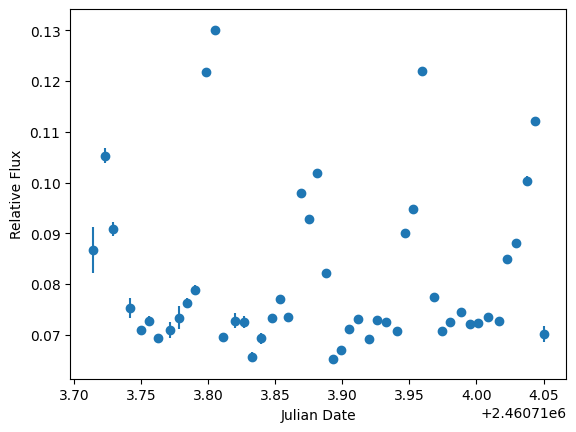

Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086
Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086
Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086
Current working directory: /Users/nathaliehaurberg/Data/MagneticCVs/Final/ST_LMi_RLMT_2025-02-07
Using filters: g


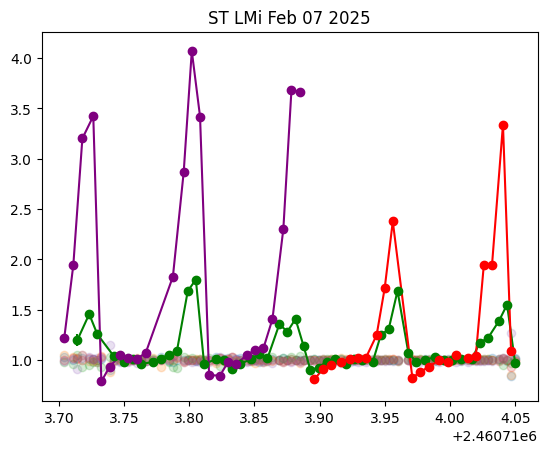

Current working directory: /Users/nathaliehaurberg/Data/MagneticCVs/Final/ST_LMi_RLMT_2025-02-07
Using filters: g


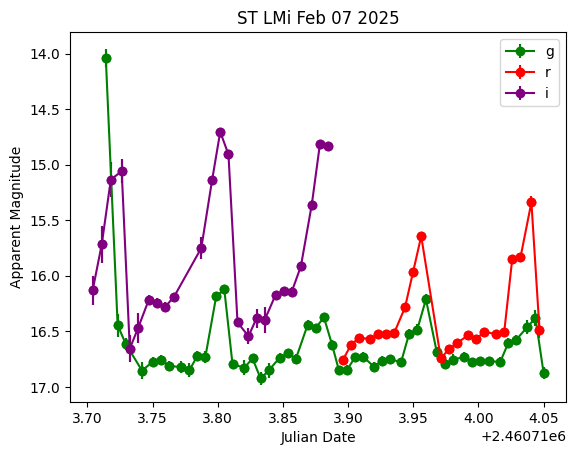

Performing photometry for filter: r
Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086


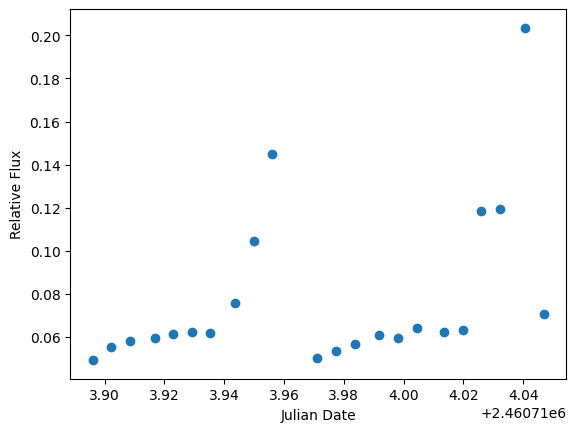

Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086
Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086
Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086
Current working directory: /Users/nathaliehaurberg/Data/MagneticCVs/Final/ST_LMi_RLMT_2025-02-07
Using filters: r


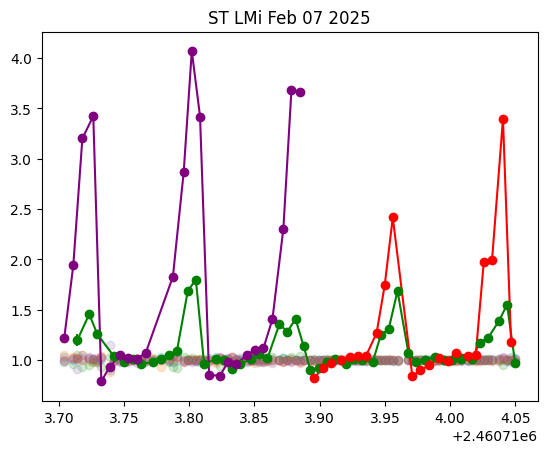

Current working directory: /Users/nathaliehaurberg/Data/MagneticCVs/Final/ST_LMi_RLMT_2025-02-07
Using filters: r


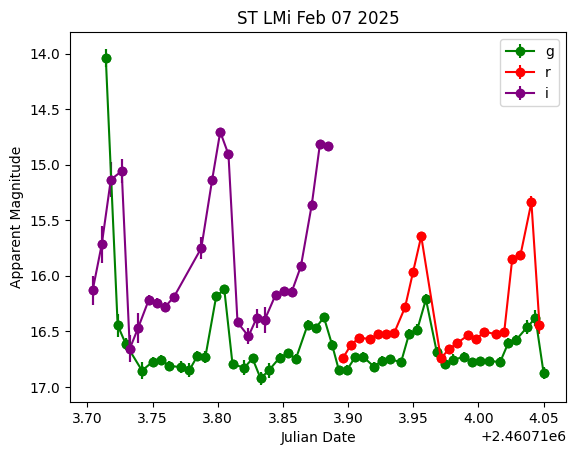

Performing photometry for filter: i
Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086


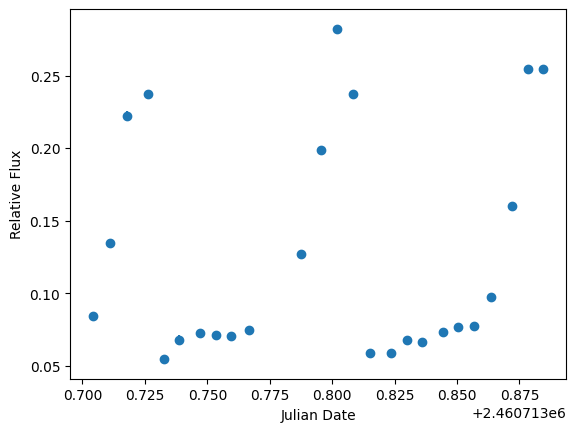

Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086
Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086
Target Name: ST_LMi
Target RA: 166.41569346642
Target Dec: 25.10798520086
Current working directory: /Users/nathaliehaurberg/Data/MagneticCVs/Final/ST_LMi_RLMT_2025-02-07
Using filters: i


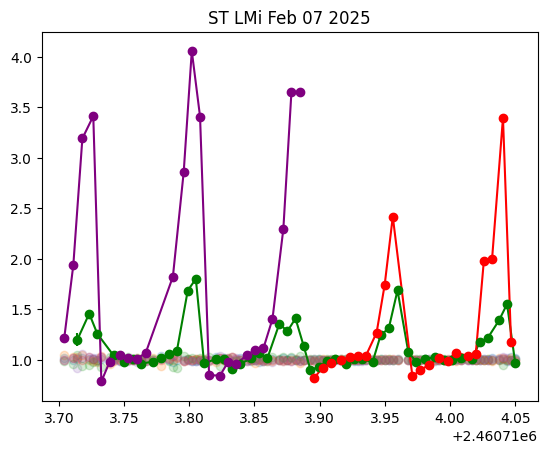

Current working directory: /Users/nathaliehaurberg/Data/MagneticCVs/Final/ST_LMi_RLMT_2025-02-07
Using filters: i


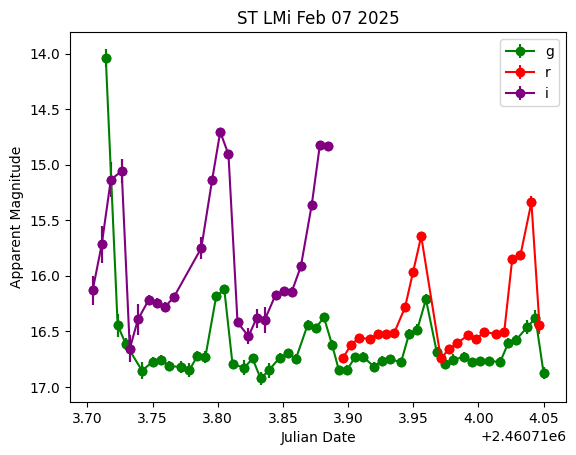

In [7]:
# Set the directory containing the image folders and the filt
BASE = '/Users/nathaliehaurberg/Data/MagneticCVs/final/ST_LMi_RLMT_2025-02-07/'

# set the star list in pixels
STARS = [(2900.2411,1477.3404), (2986.2712,1509.9692), (2412.4599,1996.4578), (2802.4384,1234.5056),(2245.5118,1043.4673)]

# set the reference image
REFERENCE_IMAGE = '/Users/nathaliehaurberg/Data/MagneticCVs/final/ST_LMi_RLMT_2025-02-28/g/mcr_ST_LMi_g_60s_2025-02-28T03-20-13.fts'

# Set the target name
TARGET_NAME = 'ST_LMi'

# Set the gain and read noise
RDNOISE = 2.8
# Gain will be found interactively approipriately for this camera

# Set the aperture and annulus radii
AP_R = 8
AN_I = 22
AN_O = 27

# Set the filters
# filters = glob.glob(BASE + '/*/')
# filters = [os.path.basename(f.rstrip('/\\')) for f in filters]
filters = ['g', 'r', 'i']

pipe = PhotometryPipeline(
    file_dir=BASE,
    star_list_pix=STARS,
    ref_image=REFERENCE_IMAGE,
    target_name=TARGET_NAME,
    rdnoise=RDNOISE,
    aperture_radius=AP_R,
    annulus_inner=AN_I,
    annulus_outer=AN_O
)

# #Run the ZP magnitude script for each filter
# for filt in filters:
#     print('Running ZP magnitude script for filter:', filt)
#     zp_runner = ZPmagrunner(base_dir=BASE, script_path='/Users/nathaliehaurberg/Data/MagneticCVs/MCV/CalcZPMag.py', flags='--rewriteAVG')
#     zp_runner.run(filt)

# Loop over the filters and perform the photometry
for filt in filters:
    print('Performing photometry for filter:', filt)
    pipe.perform_var_fwhm_phot(filt, save_ref_star_coords=False, display_apertures=False, save=True, plot=True)
    pipe.calc_ap_ratio(filt, larger_ap=18, mean=True, median=False)
    pipe.find_mags(filt, save=True, save_ref_star_coords=False, display_apertures=False)
    LightCurvePlotter.plot_relative(file_dir=BASE, filt=filt, title = 'ST LMi Feb 07 2025', comp_stars=True)
    LightCurvePlotter.plot_absolute(file_dir=BASE, title = 'ST LMi Feb 07 2025', filt=filt)